## Training data optimization


In [12]:
import sys
sys.path.append("..")

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

from example.data_utils import InfiniteDataLoader

from model import BaseHyperOptModel
from hyper_opt import FixedPointHyperOptimizer

import matplotlib.pyplot as plt
%matplotlib inline

In the paper, only linear model is considered


In [5]:
class LinearModel(nn.Module):

    def __init__(self, input_dim=28*28, num_classes=10):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(input_dim, num_classes, bias=False)
    
    def forward(self, x):
        x = self.flatten(x)
        return self.linear(x)

In [66]:
class DataDistill(BaseHyperOptModel):

    def __init__(self, input_dim=28*28, num_classes=10, beta=1.):
        network = LinearModel(input_dim=input_dim, num_classes=num_classes)
        criterion = nn.CrossEntropyLoss()
        super().__init__(network, criterion)

        self.X = nn.Parameter(torch.zeros(num_classes, input_dim))
        self.register_buffer("y", torch.arange(10).view(-1))
        self.num_classes = num_classes
        self.input_dim = input_dim
        self.denominator = float(input_dim * num_classes)
        self.beta = beta
    
    @property
    def hyper_parameters(self):
        return [self.X]
    
    def train_loss(self, train_x, train_y):
        norm_term = sum([param.norm()**2 for param in self.parameters])
        logit = self.network(self.X)
        return self.criterion(logit, self.y) + 0.5 * self.beta * norm_term / self.denominator, logit


In [61]:
batch_size = 128
lr = 0.01
base_optimizer = 'SGD'
hyper_lr = 0.01 if base_optimizer == 'RMSprop' else 0.01
device = "cuda:5"

device = torch.device(device)

Prepare data

In [62]:
batch_size = 128
data = datasets.FashionMNIST(".", train=True, download=True, transform=transforms.Compose([transforms.ToTensor()]))
data_loader = DataLoader(data, batch_size=batch_size, shuffle=True, pin_memory=True)
infty_data_loader = InfiniteDataLoader(data_loader, device)


In [67]:
model = DataDistill()
model.to(device)
w_optimizer = torch.optim.Adam(model.parameters, lr=0.01)
hyper_optimizer = FixedPointHyperOptimizer(
    model.parameters, 
    model.hyper_parameters, 
    default=dict(lr=hyper_lr),
    stochastic=False)
hyper_optimizer.set_kwargs(inner_lr=lr, K=20)


In [68]:
def train_loss_func():
    # this case inner loss take nothing from train data
    return model.train_loss(None, None)

In [71]:
T = 10
n_iter=1000
for i in range(n_iter):

    for t in range(T):
        w_optimizer.zero_grad()
        loss, _ = train_loss_func()
        loss.backward()
        w_optimizer.step()
    
    x_val, y_val = infty_data_loader.next_batch()
    val_loss = model.validation_loss(x_val, y_val)
    hyper_optimizer.step(train_loss_func, val_loss)
    
    if i % 10 == 0 and i > 0:
        print(f"Iter {i} \t Val loss {val_loss.item():.3f}")


Iter 10 	 Val loss 0.717
Iter 20 	 Val loss 0.644
Iter 30 	 Val loss 0.747
Iter 40 	 Val loss 0.780
Iter 50 	 Val loss 0.803
Iter 60 	 Val loss 0.636
Iter 70 	 Val loss 0.641
Iter 80 	 Val loss 0.773
Iter 90 	 Val loss 0.677
Iter 100 	 Val loss 0.782
Iter 110 	 Val loss 0.512
Iter 120 	 Val loss 0.636
Iter 130 	 Val loss 0.869
Iter 140 	 Val loss 1.363
Iter 150 	 Val loss 0.695
Iter 160 	 Val loss 0.586
Iter 170 	 Val loss 0.617
Iter 180 	 Val loss 1.183
Iter 190 	 Val loss 0.772
Iter 200 	 Val loss 0.656
Iter 210 	 Val loss 0.778
Iter 220 	 Val loss 0.710
Iter 230 	 Val loss 1.290
Iter 240 	 Val loss 0.804
Iter 250 	 Val loss 0.773
Iter 260 	 Val loss 0.505
Iter 270 	 Val loss 0.680
Iter 280 	 Val loss 0.925
Iter 290 	 Val loss 1.051
Iter 300 	 Val loss 0.612
Iter 310 	 Val loss 1.149
Iter 320 	 Val loss 0.647
Iter 330 	 Val loss 0.513
Iter 340 	 Val loss 0.641
Iter 350 	 Val loss 0.475
Iter 360 	 Val loss 1.185
Iter 370 	 Val loss 0.655
Iter 380 	 Val loss 0.568
Iter 390 	 Val loss 0

In [73]:
X = model.X.detach().clone().cpu().numpy()

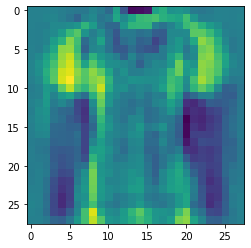

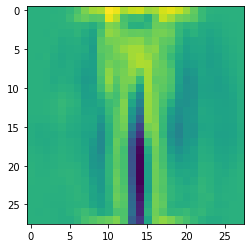

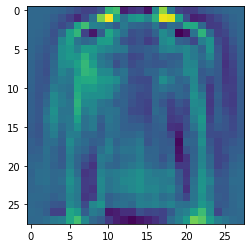

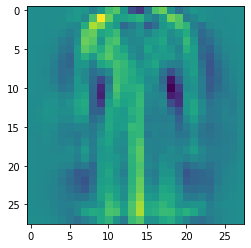

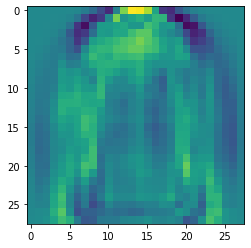

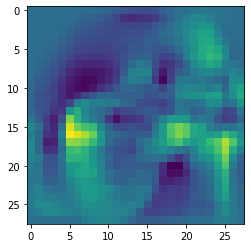

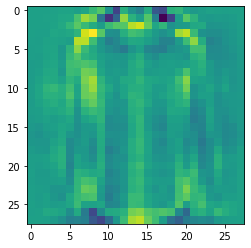

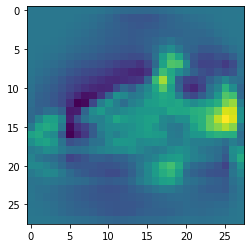

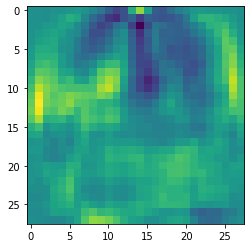

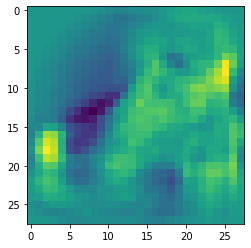

In [75]:
import numpy as np
for i in range(10):
    X_i = X[i]
    X_i = np.reshape(X_i, (28,28))
    plt.figure()
    plt.imshow(X_i)
